#COMP90089: Machine Learning Applications for Health Semester 2, 2024
#Assignment 2 - 1281413 - Divyanshu Mishra

In [65]:
#Importing necasary libraries
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)



#Reading the input file, ensure to replace with your appropriate filename and path when running locally
cohort_df = pd.read_csv('/content/hypotension_patients.csv')

#Checking for missing values
nan_counts_per_column = cohort_df.isna().sum()
print(nan_counts_per_column)

total_nan_count = cohort_df.isna().sum().sum()
print(total_nan_count)


ID                               0
anchor_age                       0
gender                           0
dod                           1816
apsiii                           0
LoS                              0
charlson_comorbidity_index       0
dtype: int64
1816


In [66]:
cohort_df['dod'] = cohort_df['dod'].astype('datetime64[ns]')  # Converting 'dod' to datetime format

# Summary statistics for continuous variables
summary_continuous = cohort_df[['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']].describe()

# Summary statistics for categorical variables
summary_gender = cohort_df['gender'].value_counts(normalize=True) * 100

# Summary statistics for date variables ('dod')
survival_count = cohort_df['dod'].isna().sum()
deceased_count = cohort_df['dod'].notna().sum()
mortality_rate = (deceased_count / (survival_count + deceased_count)) * 100

# Correlation between variables
correlation_matrix = cohort_df[['apsiii', 'LoS', 'charlson_comorbidity_index']].corr()

summary_continuous, summary_gender, survival_count, deceased_count, mortality_rate, correlation_matrix

(        anchor_age       apsiii          LoS  charlson_comorbidity_index
 count  5106.000000  5106.000000  5106.000000                  5106.00000
 mean     65.552683    60.314532     7.053651                     5.21700
 std      15.235907    28.860171     8.432716                     2.57691
 min      18.000000     3.000000     0.040000                     0.00000
 25%      56.000000    38.000000     1.960000                     4.00000
 50%      67.000000    53.000000     4.130000                     5.00000
 75%      77.000000    78.000000     8.960000                     7.00000
 max      91.000000   189.000000   103.500000                    19.00000,
 gender
 M    55.875441
 F    44.124559
 Name: proportion, dtype: float64,
 1816,
 3290,
 64.4339992166079,
                               apsiii       LoS  charlson_comorbidity_index
 apsiii                      1.000000  0.202155                    0.154213
 LoS                         0.202155  1.000000                   -0.0211

#**Q1 Summary Statistics** & **EDA**
**Describe via summary statistics the main properties of the profound hypotension cohort. (Up to 200 words. Also provide plots for visualising the distributions).**

The profound hypotension cohort includes 5,106 patients, with **55.88% male and 44.12% female**. The average age is **65.55 years**, with most patients being older adults, a group particularly vulnerable to severe health issues like hypotension.

The **Acute Physiology Score III (APSIII)**, which measures illness severity, averages **60.31**, indicating serious health challenges. Some patients have lower APSIII scores, while others face extreme severity, with scores as high as **189**.

**Length of Stay (LoS)** in the ICU varies widely. On average, patients stay **7.05 days**, though some only need a few hours of care, while others remain for over **100 days**.

The **Charlson Comorbidity Index** averages at **5.21**, showing that many patients have multiple underlying health conditions, adding complexity to their treatment and prognosis.

In summary, this cohort consists of older, seriously ill patients who often face multiple health challenges. Their ICU stay reflects their fight for survival, with varying levels of illness and complexity.

Here are some visuals to illustrate these insights:
- **Anchor Ages Graph**: Most patients are in their 60s and 70s.
- **APSIII Score Distribution**: Varies from mild to critically severe.
- **Length of Stay**: ICU stays range from hours to months.
- **Charlson Comorbidity Index**: Many patients have multiple conditions.


# Anchor Ages Graph

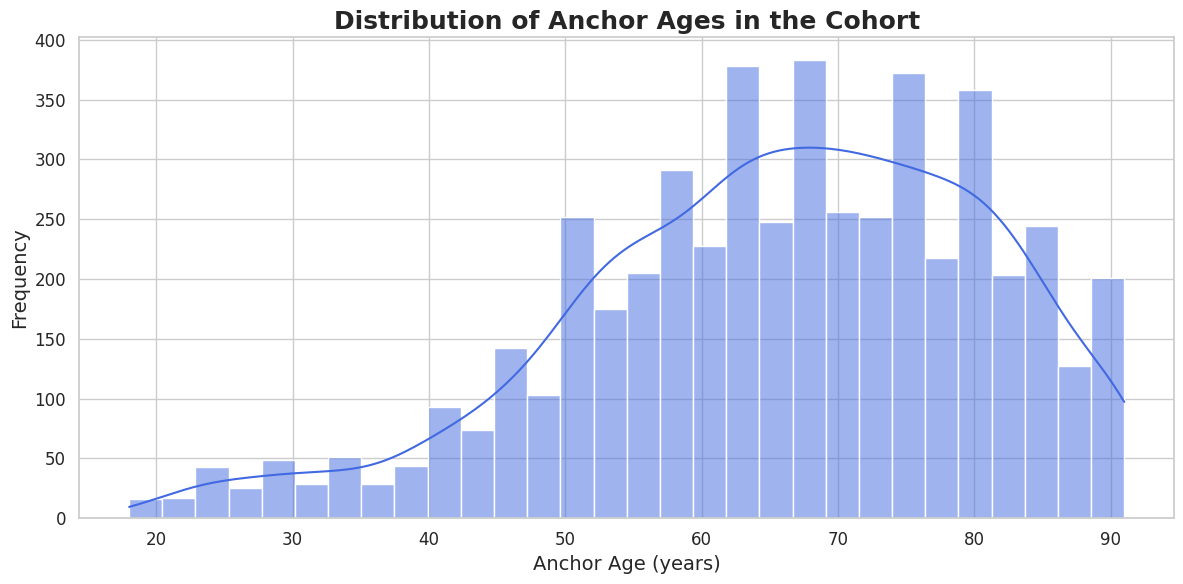

In [67]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plotting the distribution of 'anchor_age'
sns.histplot(cohort_df['anchor_age'], bins=30, kde=True, color='royalblue')

plt.title('Distribution of Anchor Ages in the Cohort', fontsize=18, weight='bold')
plt.xlabel('Anchor Age (years)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


### Anchor Age Graph Summary

The **Anchor Age Distribution** shows most of the 5,106 patients are aged **60-80**, with a peak around **65-70 years**. Older adults dominate the cohort, highlighting their higher vulnerability to profound hypotension due to age-related health issues. This emphasizes the need for **age-specific care** and tailored treatments for elderly patients.

In [68]:
#Installing lifelines library
!pip install lifelines

# Kaplan-Meier Survival Curve

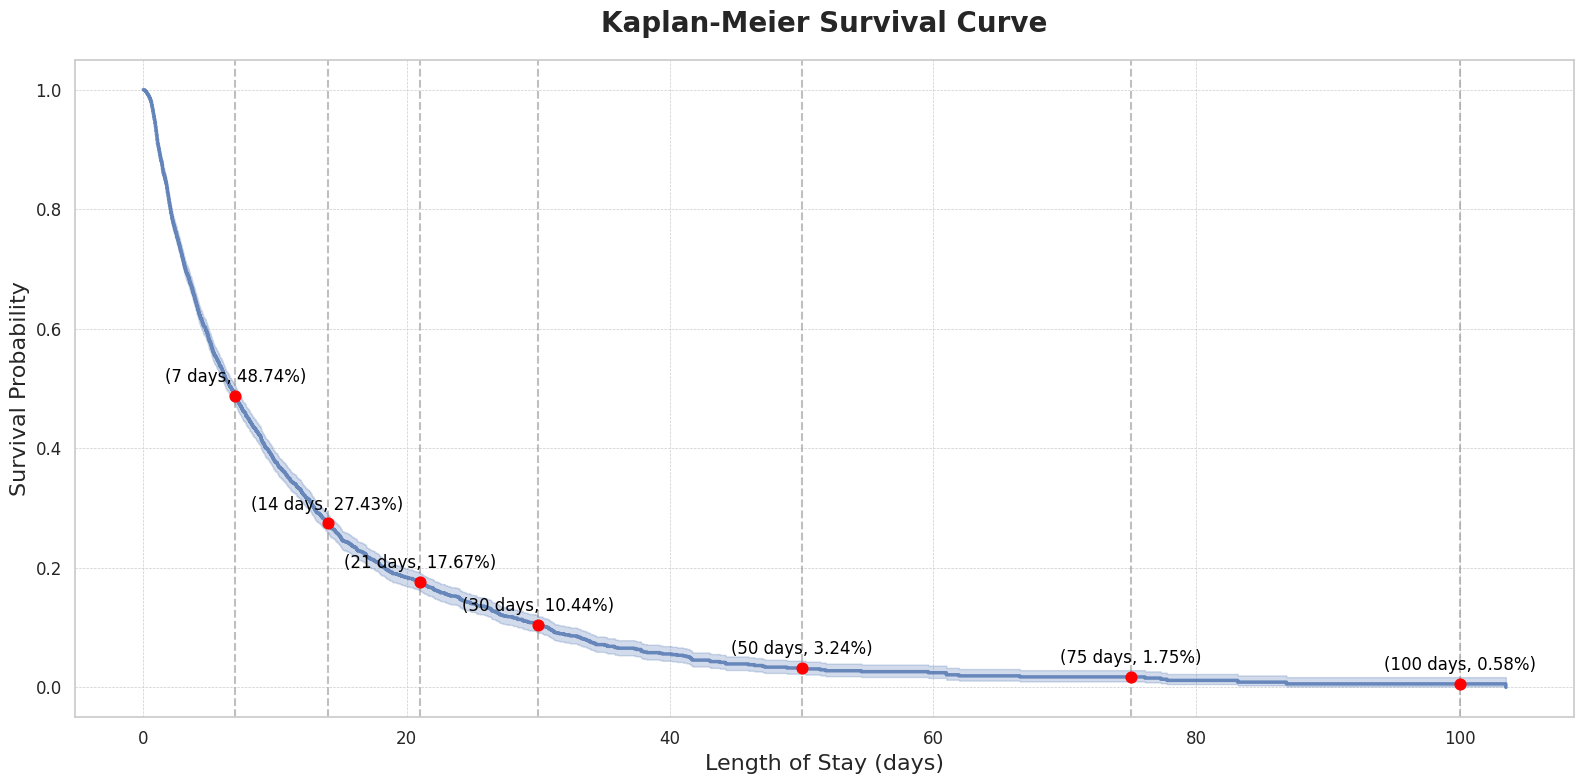

In [69]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Create an 'event' column (1 if death occurred, 0 otherwise)
cohort_df['event'] = ~cohort_df['dod'].isna()

# Initialize the Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Fit the data into the model
kmf.fit(cohort_df['LoS'], event_observed=cohort_df['event'])

# Initialize a list to store intersection coordinates
intersection_points = []

# Generate Kaplan-Meier Survival Curve
plt.figure(figsize=(16, 8))
ax = kmf.plot(color='b', linewidth=2.5, alpha=0.8, legend=False)

# Add title and labels
plt.title('Kaplan-Meier Survival Curve', fontsize=20, weight='bold', pad=20)
plt.xlabel('Length of Stay (days)', fontsize=16)
plt.ylabel('Survival Probability', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate intersection points and add vertical lines
for day in [7, 14, 21, 30, 50, 75, 100]:
    survival_prob = kmf.predict(day)
    intersection_points.append((day, survival_prob))
    plt.scatter(day, survival_prob, color='red', s=60, zorder=5)  # Emphasize intersection points
    plt.annotate(f"({day} days, {survival_prob*100:.2f}%)", (day, survival_prob), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='black')
    plt.axvline(x=day, color='grey', linestyle='--', alpha=0.5)

# Adjust grid appearance
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Remove any unwanted legend
if plt.legend() is not None:
    plt.legend().remove()

plt.tight_layout()
plt.show()



In [70]:
# Display intersection points for reference
print(intersection_points)


[(7, 0.48740412110262804), (14, 0.27430152364699295), (21, 0.17669617104281785), (30, 0.10442852555586726), (50, 0.03242614853511397), (75, 0.01749982619355357), (100, 0.0058332753978511875)]


### Kaplan-Meier Curve Summary

The **Kaplan-Meier Survival Curve** shows a sharp drop in survival for patients with profound hypotension, especially in the first **14 days**. By **30 days**, only **10.44%** of patients survive, and by **100 days**, survival drops to just **0.58%**. This highlights the critical need for **early interventions** to improve outcomes, as survival decreases rapidly with extended ICU stays. It suggests that underlying conditions and complications may worsen survival chances, stressing the importance of targeted, timely treatments.

# APSII and Charlson Comorbidity Index

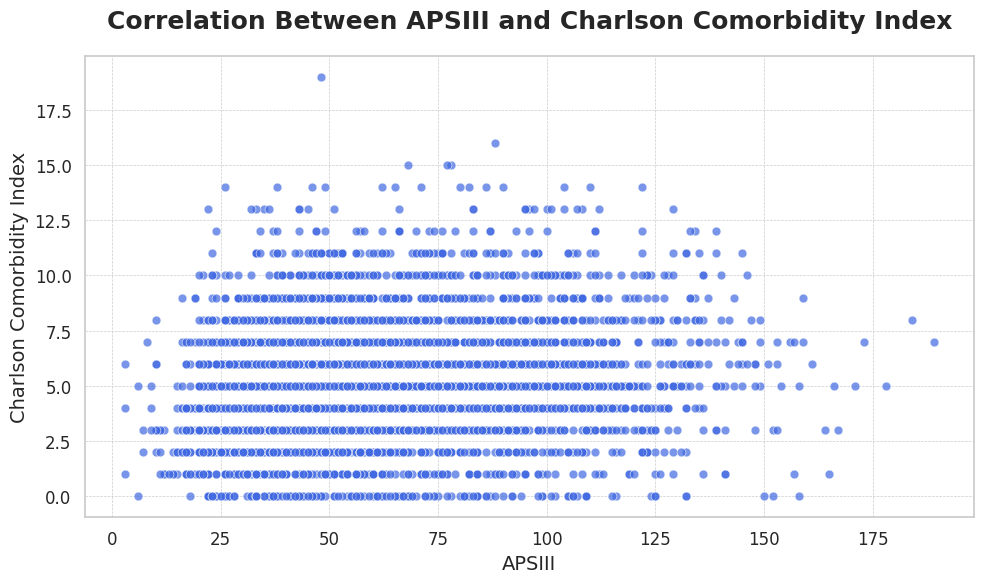

In [71]:
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation between APSIII and Charlson Comorbidity Index
correlation_value = cohort_df['apsiii'].corr(cohort_df['charlson_comorbidity_index'])

# Set Seaborn theme for better visuals
sns.set_theme(style="whitegrid")

# Plotting the correlation graph with smaller points
plt.figure(figsize=(10, 6))
sns.scatterplot(x='apsiii', y='charlson_comorbidity_index', data=cohort_df, color='royalblue', s=40, alpha=0.7)

# Enhancing title and axis labels
plt.title('Correlation Between APSIII and Charlson Comorbidity Index', fontsize=18, weight='bold', pad=20)
plt.xlabel('APSIII', fontsize=14)
plt.ylabel('Charlson Comorbidity Index', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding gridlines
plt.grid(True, linestyle='--', linewidth=0.5)

# Displaying the plot
plt.tight_layout()
plt.show()



In [72]:
# Printing the correlation value
correlation_value

0.15421333516078342

### APSIII and Charlson Comorbidity Index Scatter Plot Summary

This scatter plot shows a **moderate positive correlation** (**0.154**) between the **APSIII score** (illness severity) and the **Charlson Comorbidity Index** (chronic conditions). While sicker patients often have more comorbidities, the relationship isn’t strong—some patients with severe illness have few chronic conditions. This highlights the need to consider both **acute and chronic** health issues in ICU care planning.

# Correlation Heatmap


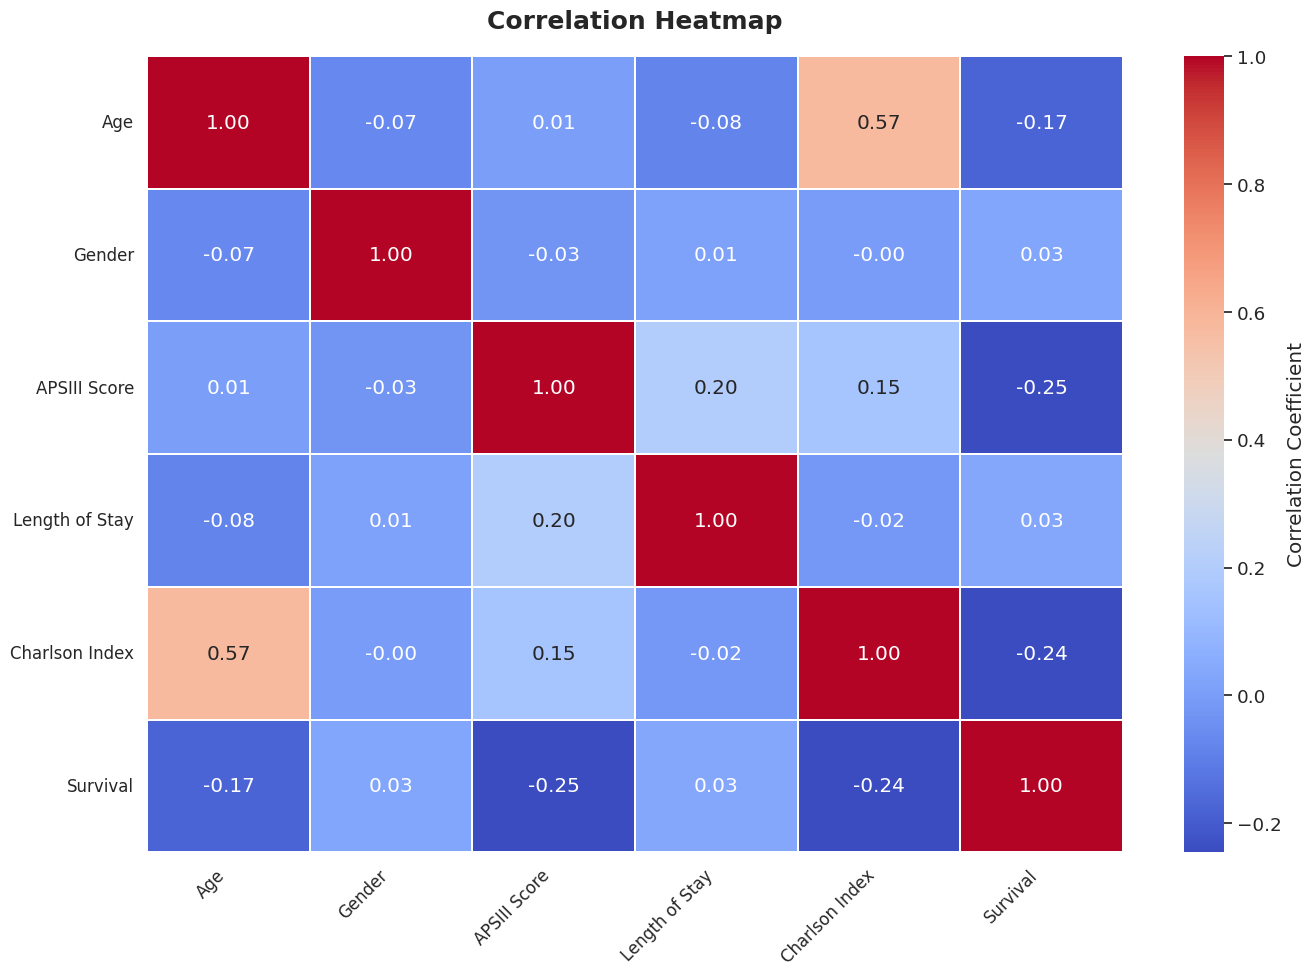

In [73]:
# Rename features for better readability in the graph
feature_names = {
    'anchor_age': 'Age',
    'gender_numeric': 'Gender',
    'apsiii': 'APSIII Score',
    'LoS': 'Length of Stay',
    'charlson_comorbidity_index': 'Charlson Index',
    'survival': 'Survival'
}

# Convert 'gender' to a numeric variable (F:0, M:1) and 'dod' to a binary outcome variable (1: died, 0: survived)
cohort_df['gender_numeric'] = cohort_df['gender'].map({'F': 0, 'M': 1})
cohort_df['survival'] = cohort_df['dod'].isna().astype(int)

# Calculate the correlation matrix including 'gender_numeric' and 'survival'
correlation_matrix_with_gender_survival = cohort_df[['anchor_age', 'gender_numeric', 'apsiii', 'LoS', 'charlson_comorbidity_index', 'survival']].corr()

# Update the correlation matrix with the renamed features
correlation_matrix_renamed = correlation_matrix_with_gender_survival.rename(columns=feature_names, index=feature_names)

# Plotting the enhanced correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.2)

# Creating the heatmap with improved visuals
sns.heatmap(correlation_matrix_renamed, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3, cbar_kws={'label': 'Correlation Coefficient'})

# Title and layout enhancements
plt.title('Correlation Heatmap', fontsize=18, weight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show plot
plt.show()


### Correlation Heatmap Summary

The **Correlation Heatmap** shows key insights:
- **Age and Comorbidity Index** correlate positively (**0.57**).
- **APSIII and Survival** are negatively correlated (**-0.25**).
- **APSIII and LoS** have a weak positive correlation (**0.20**).
- More comorbidities (**Charlson Index**) link to lower survival (**-0.24**).
- **Gender** doesn’t significantly affect outcomes.

These relationships help identify connections between patient characteristics and outcomes.

# Dataset Graphs

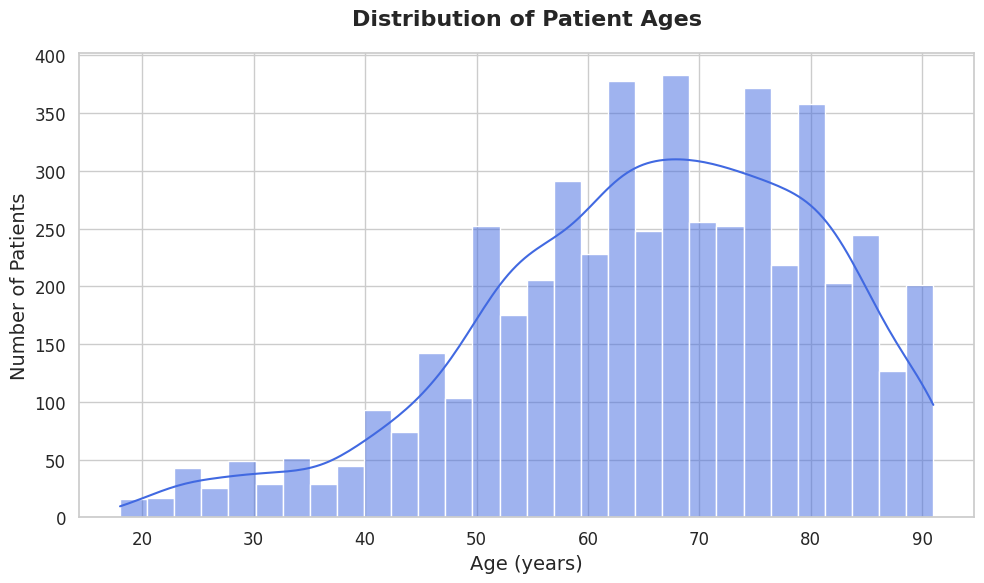

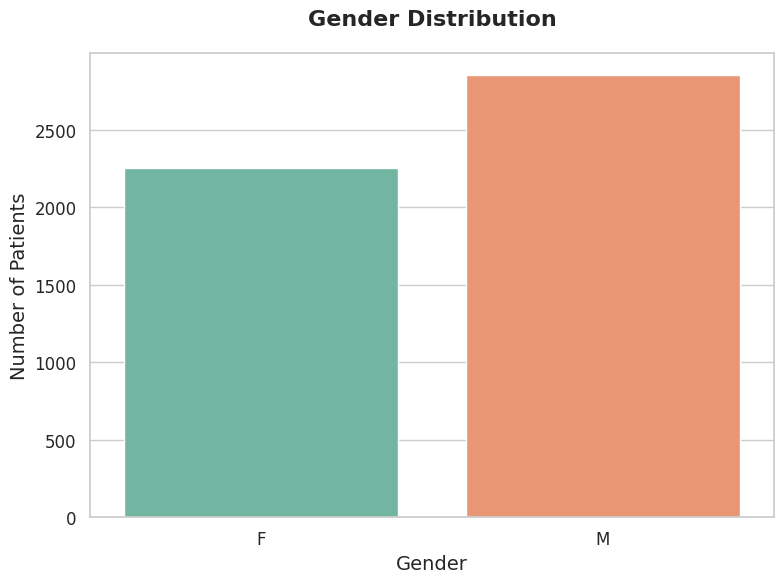

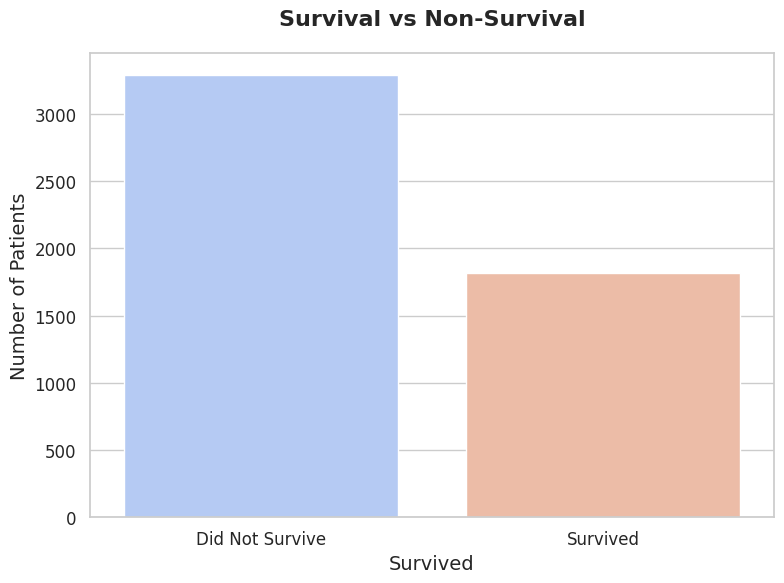

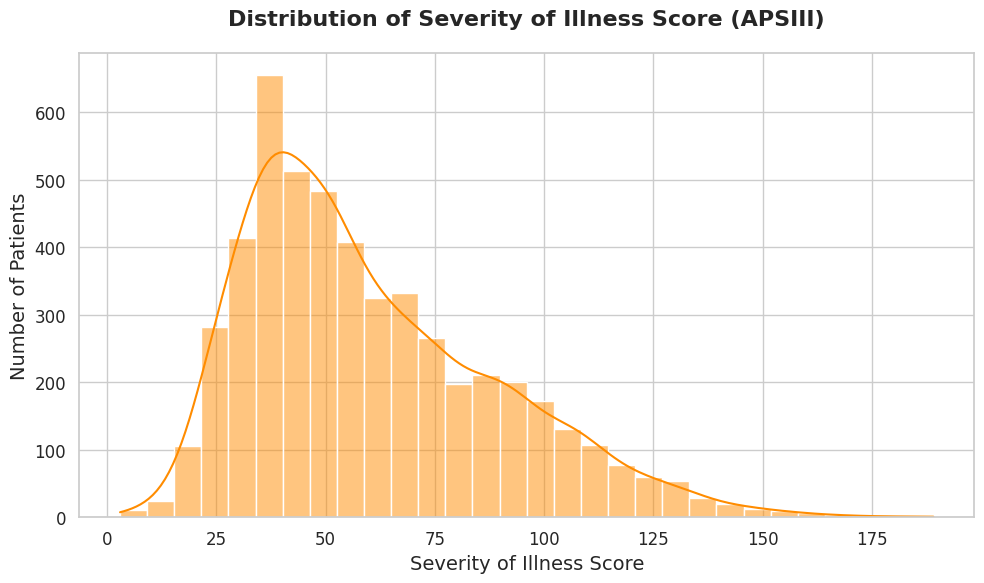

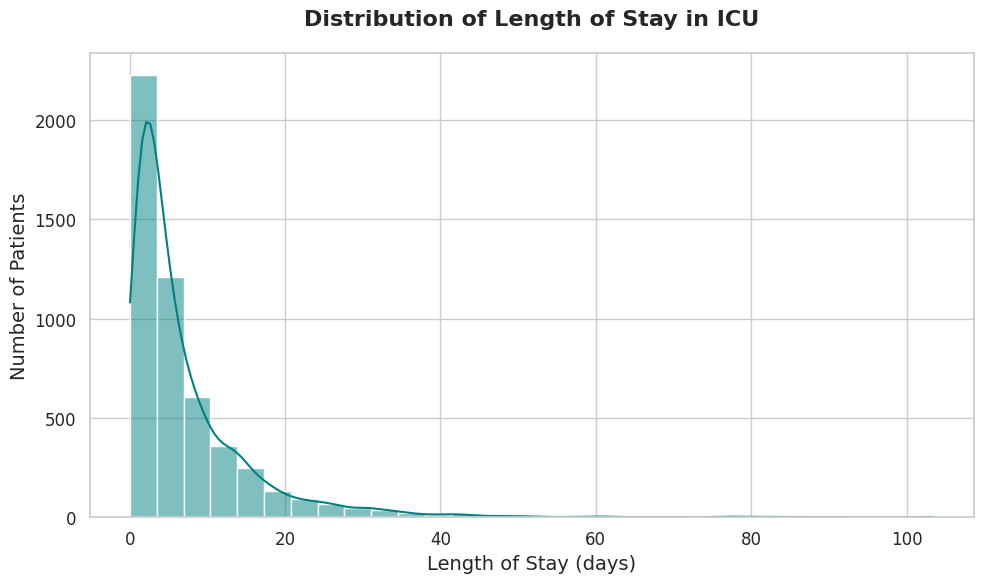

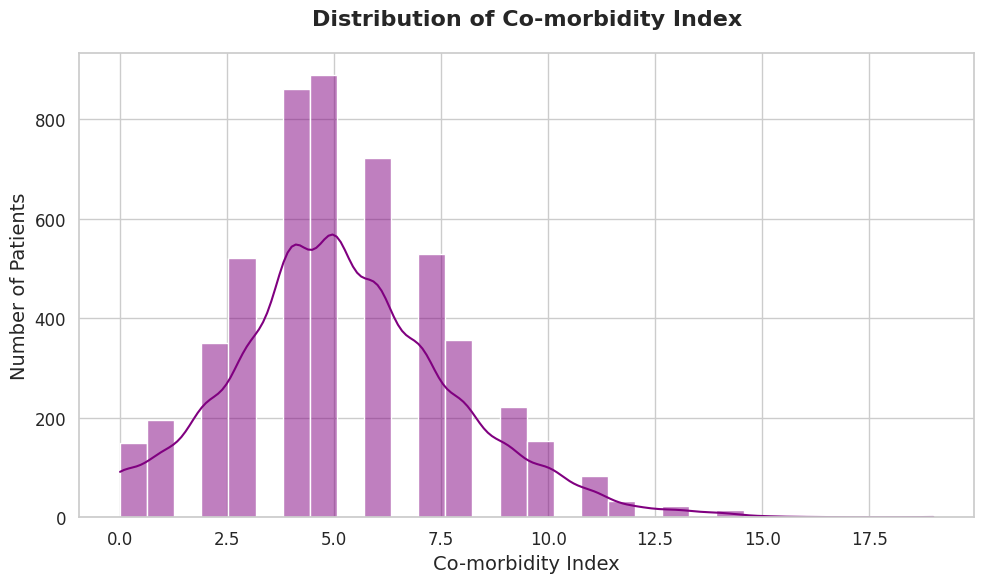

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for seaborn plots
sns.set_theme(style="whitegrid")

# 1. anchor_age: Distribution of Patient Ages
plt.figure(figsize=(10, 6))
sns.histplot(cohort_df['anchor_age'], bins=30, kde=True, color='royalblue')
plt.title('Distribution of Patient Ages', fontsize=16, weight='bold', pad=20)
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 2. gender: Gender Distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=cohort_df, x='gender', hue='gender', palette='Set2', dodge=False, legend=False)
plt.title('Gender Distribution', fontsize=16, weight='bold', pad=20)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 3. dod: Survival vs Non-Survival
cohort_df['Survival'] = cohort_df['dod'].isna()
plt.figure(figsize=(8, 6))
sns.countplot(data=cohort_df, x='Survival', hue='Survival', palette='coolwarm', dodge=False, legend=False)
plt.title('Survival vs Non-Survival', fontsize=16, weight='bold', pad=20)
plt.xlabel('Survived', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks([0, 1], ['Did Not Survive', 'Survived'], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 4. apsiii: Distribution of Severity of Illness Score (apsiii)
plt.figure(figsize=(10, 6))
sns.histplot(cohort_df['apsiii'], bins=30, kde=True, color='darkorange')
plt.title('Distribution of Severity of Illness Score (APSIII)', fontsize=16, weight='bold', pad=20)
plt.xlabel('Severity of Illness Score', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 5. LoS: Distribution of Length of Stay in ICU
plt.figure(figsize=(10, 6))
sns.histplot(cohort_df['LoS'], bins=30, kde=True, color='teal')
plt.title('Distribution of Length of Stay in ICU', fontsize=16, weight='bold', pad=20)
plt.xlabel('Length of Stay (days)', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 6. charlson_comorbidity_index: Distribution of Co-morbidity Index
plt.figure(figsize=(10, 6))
sns.histplot(cohort_df['charlson_comorbidity_index'], bins=30, kde=True, color='purple')
plt.title('Distribution of Co-morbidity Index', fontsize=16, weight='bold', pad=20)
plt.xlabel('Co-morbidity Index', fontsize=14)
plt.ylabel('Number of Patients', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


#More Graphs

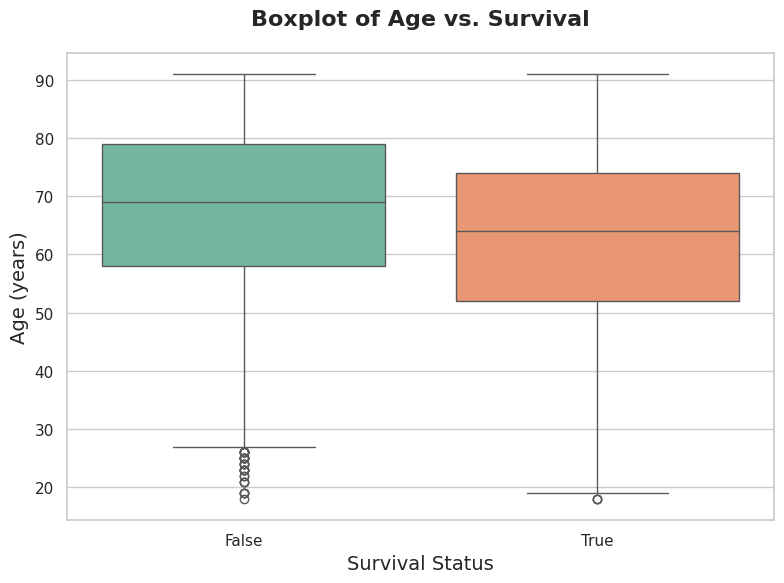

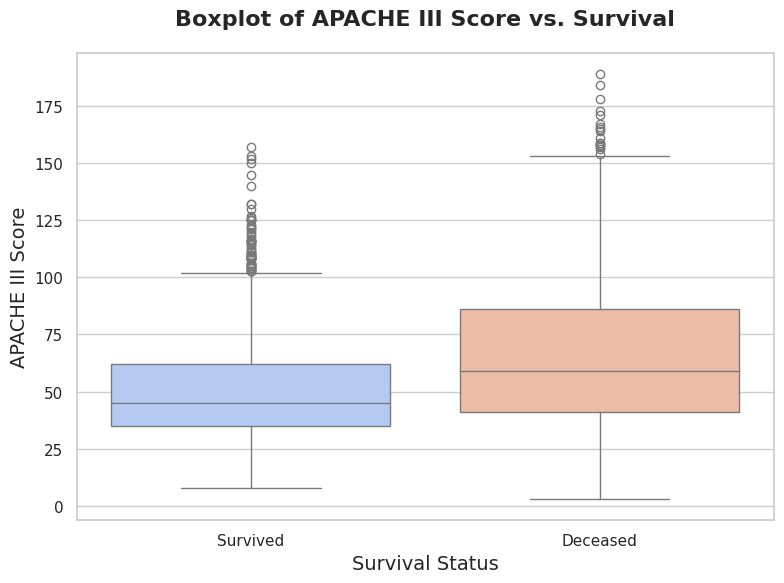

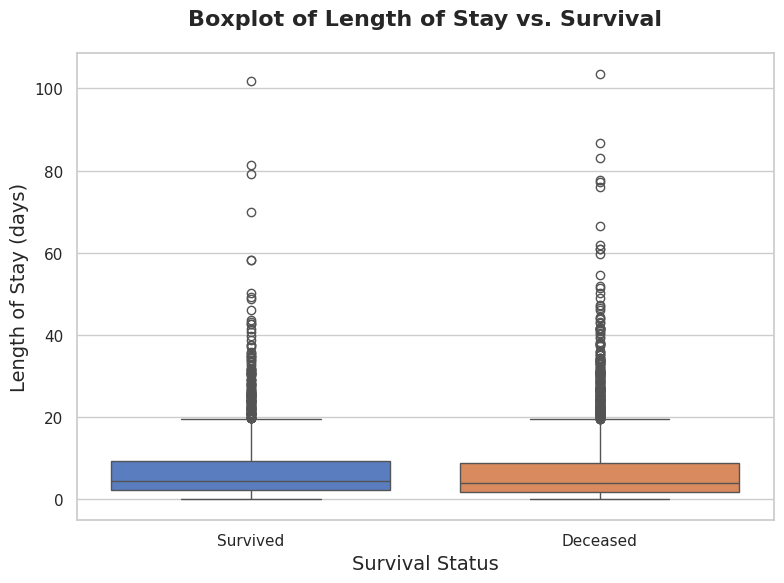

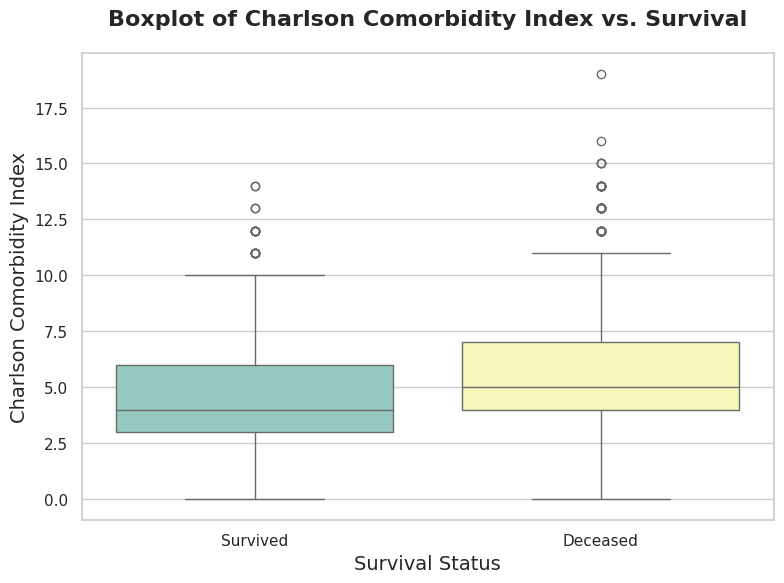

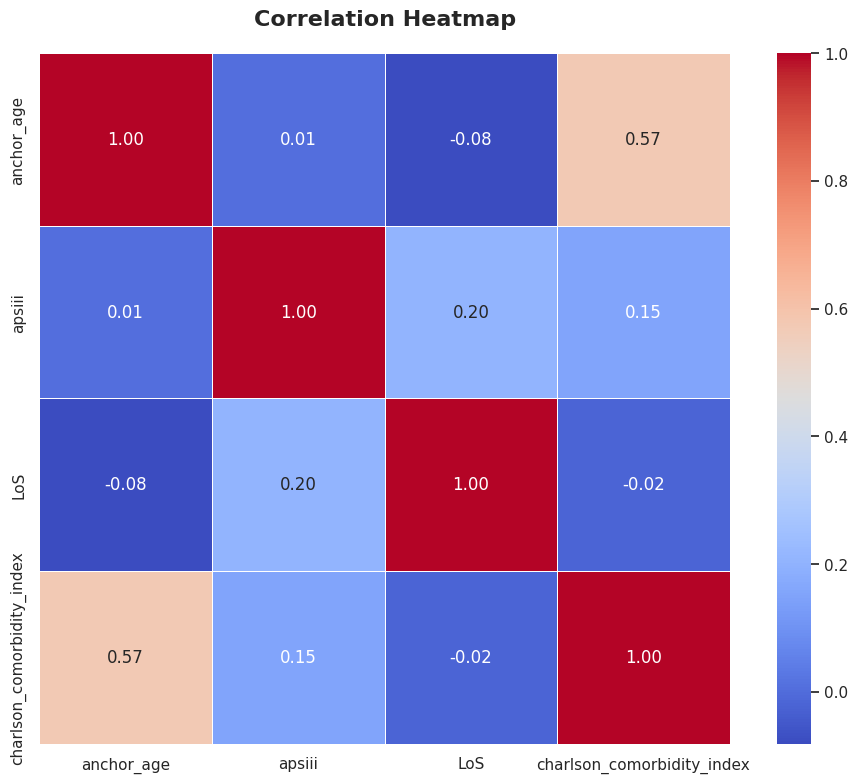

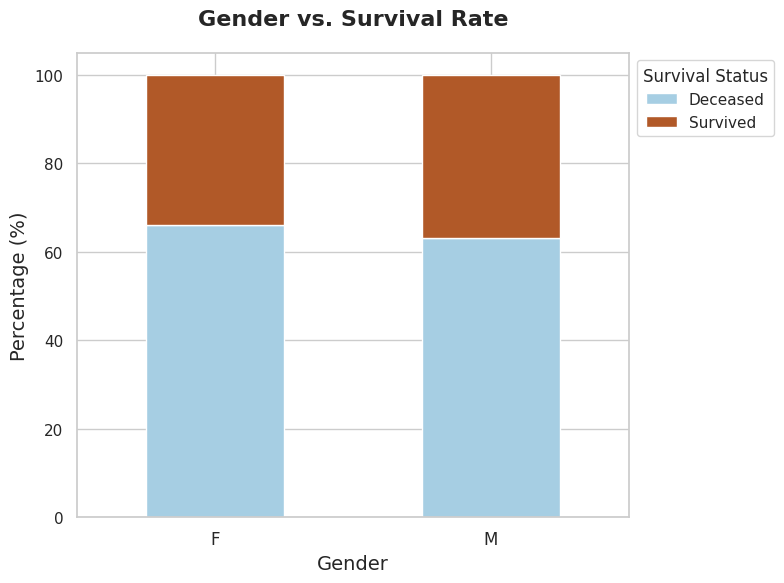

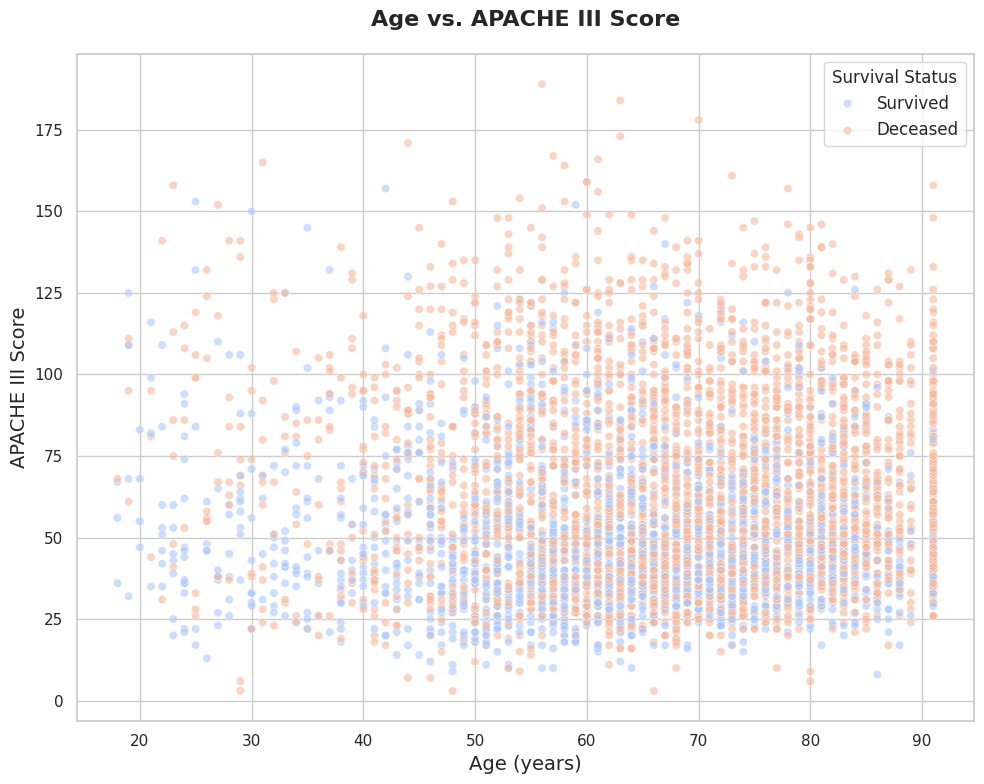

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# Setting the style for seaborn plots
sns.set_theme(style="whitegrid")

# Boxplot of Age vs. Survival
plt.figure(figsize=(8, 6))
sns.boxplot(data=cohort_df, x='Survival', y='anchor_age', hue='Survival', palette="Set2", dodge=False, legend=False)
plt.title('Boxplot of Age vs. Survival', fontsize=16, weight='bold', pad=20)
plt.xlabel('Survival Status', fontsize=14)
plt.ylabel('Age (years)', fontsize=14)
plt.tight_layout()
plt.show()

# Creating a 'Survival' column for visualization purposes
cohort_df['Survival'] = cohort_df['dod'].isna().map({True: 'Survived', False: 'Deceased'})

# Boxplot of APACHE III Score vs. Survival
plt.figure(figsize=(8, 6))
sns.boxplot(data=cohort_df, x='Survival', y='apsiii', hue='Survival', palette="coolwarm", dodge=False, legend=False)
plt.title('Boxplot of APACHE III Score vs. Survival', fontsize=16, weight='bold', pad=20)
plt.xlabel('Survival Status', fontsize=14)
plt.ylabel('APACHE III Score', fontsize=14)
plt.tight_layout()
plt.show()

# Boxplot of Length of Stay vs. Survival
plt.figure(figsize=(8, 6))
sns.boxplot(data=cohort_df, x='Survival', y='LoS', hue='Survival', palette="muted", dodge=False, legend=False)
plt.title('Boxplot of Length of Stay vs. Survival', fontsize=16, weight='bold', pad=20)
plt.xlabel('Survival Status', fontsize=14)
plt.ylabel('Length of Stay (days)', fontsize=14)
plt.tight_layout()
plt.show()

# Boxplot of Charlson Comorbidity Index vs. Survival
plt.figure(figsize=(8, 6))
sns.boxplot(data=cohort_df, x='Survival', y='charlson_comorbidity_index', hue='Survival', palette="Set3", dodge=False, legend=False)
plt.title('Boxplot of Charlson Comorbidity Index vs. Survival', fontsize=16, weight='bold', pad=20)
plt.xlabel('Survival Status', fontsize=14)
plt.ylabel('Charlson Comorbidity Index', fontsize=14)
plt.tight_layout()
plt.show()

# Correlation Heatmap for numerical variables
correlation_matrix = cohort_df[['anchor_age', 'apsiii', 'LoS', 'charlson_comorbidity_index']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title('Correlation Heatmap', fontsize=16, weight='bold', pad=20)
plt.tight_layout()
plt.show()

# Gender vs. Survival Rate
gender_survival_rate = cohort_df.groupby('gender')['Survival'].value_counts(normalize=True).unstack() * 100
gender_survival_rate.plot(kind='bar', stacked=True, figsize=(8, 6), colormap="Paired")
plt.title('Gender vs. Survival Rate', fontsize=16, weight='bold', pad=20)
plt.ylabel('Percentage (%)', fontsize=14)
plt.xlabel('Gender', fontsize=14)
plt.legend(title='Survival Status', loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# Scatterplot of Age vs. APACHE III Score
plt.figure(figsize=(10, 8))
sns.scatterplot(data=cohort_df, x='anchor_age', y='apsiii', hue='Survival', palette="coolwarm", alpha=0.6)
plt.title('Age vs. APACHE III Score', fontsize=16, weight='bold', pad=20)
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('APACHE III Score', fontsize=14)
plt.legend(title='Survival Status', fontsize=12)
plt.tight_layout()
plt.show()


# **Q2. K-Means Clustering**

**Perform k-means clustering to identify subgroups of patients. Use the elbow criteria to identify an adequate number of clusters. Justify your choice. Since selecting clusters based on elbow criteria is a heuristic, you may select two different values of k for further analysis. (Up to 300 words. Provide a plot to justify the number of clusters chosen).**


# Data Preparation

In [76]:
cohort_df = pd.read_csv('/content/hypotension_patients.csv')

print(cohort_df.isna().sum())

ID                               0
anchor_age                       0
gender                           0
dod                           1816
apsiii                           0
LoS                              0
charlson_comorbidity_index       0
dtype: int64


In [77]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Handle the 'dod' column by creating a binary 'survived' column: 1 if survived, 0 otherwise
cohort_df['survived'] = cohort_df['dod'].isna().astype(int)

# Drop the 'dod' and 'ID' columns as they won't be useful for clustering
cohort_df.drop(['dod', 'ID'], axis=1, inplace=True)

# Encode the 'gender' column
le = LabelEncoder()
cohort_df['gender'] = le.fit_transform(cohort_df['gender'])

# Standardise the numerical variables
scaler = StandardScaler()
cohort_df_scaled = pd.DataFrame(scaler.fit_transform(cohort_df), columns=cohort_df.columns)

# Display the first few rows of the preprocessed data
cohort_df_scaled.head()


,anchor_age,gender,apsiii,LoS,charlson_comorbidity_index,survived
0,0.948334,-1.125305,-0.149512,-0.006363,-0.472317,1.345984
1,0.423207,-1.125305,-0.392085,0.695734,0.303882,-0.742951
2,1.079616,0.888648,-0.496045,0.720639,-0.084217,-0.742951
3,1.539102,-1.125305,0.890084,-0.253045,0.691982,-0.742951
4,0.226285,-1.125305,1.444536,0.522581,1.080082,-0.742951


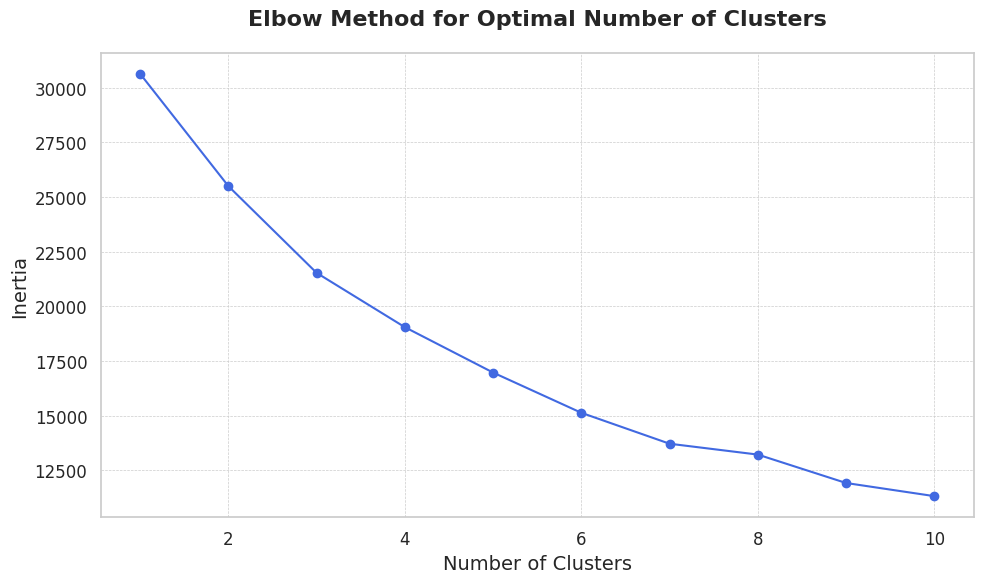

Number of Clusters vs Inertia Values:
1 clusters: Inertia = 30636.00
2 clusters: Inertia = 25496.73
3 clusters: Inertia = 21527.77
4 clusters: Inertia = 19043.30
5 clusters: Inertia = 16965.76
6 clusters: Inertia = 15125.08
7 clusters: Inertia = 13709.96
8 clusters: Inertia = 13213.23
9 clusters: Inertia = 11913.01
10 clusters: Inertia = 11311.60


In [78]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn theme for better visuals
sns.set_theme(style="whitegrid")

# Determine the optimal number of clusters using the elbow method
inertia_values = []
range_clusters = range(1, 11)

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)  # 'n_init' updated to avoid future warnings
    kmeans.fit(cohort_df_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range_clusters, inertia_values, marker='o', color='royalblue')
plt.title("Elbow Method for Optimal Number of Clusters", fontsize=16, weight='bold', pad=20)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Print the inertia values for reference
print("Number of Clusters vs Inertia Values:")
for k, inertia in zip(range_clusters, inertia_values):
    print(f"{k} clusters: Inertia = {inertia:.2f}")


## K-Means Clustering & Elbow Criteria Analysis

### Elbow Criteria to Identify Optimal Number of Clusters

To determine the best number of clusters for segmenting the profound hypotension patient cohort, I used the **elbow method**. This approach helps identify where adding more clusters doesn’t significantly reduce the **inertia** (the sum of squared distances between data points and their closest cluster center). The "elbow" of the curve is the point where further increases in the number of clusters yield diminishing returns in improving the model.

The inertia values for different numbers of clusters were:
- **1 cluster**: 30,636.00
- **2 clusters**: 25,496.73
- **3 clusters**: 21,527.77
- **4 clusters**: 19,043.30
- **5 clusters**: 16,965.76
- **6 clusters**: 15,125.08
- **7 clusters**: 13,709.96

The **elbow plot** of these values showed a steep drop in inertia up to **3 clusters**, after which the rate of improvement slows down. This suggests that **3 clusters** is an adequate number for dividing the patient cohort, as adding more clusters doesn’t result in significant gains.

However, because the inertia continues to drop noticeably between **4 and 5 clusters**, I decided to explore **5 clusters** as well. The reduction between **5 and 7 clusters** was smaller, suggesting that adding further clusters beyond **5** might not provide useful differentiation.

Thus, I selected **3 and 5 clusters** for further analysis. These values strike a balance between capturing meaningful subgroups in the data while avoiding overfitting with too many clusters. This allows me to better understand the distribution of patient characteristics and outcomes across distinct groups.

Below are the elbow plots justifying these choices



In [79]:
k_values = [3, 5, 7]
cluster_labels = {}
cluster_summary = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    cluster_labels[k] = kmeans.fit_predict(cohort_df_scaled)

for k, labels in cluster_labels.items():
    cohort_df[f'Cluster_{k}'] = labels

for k in k_values:
    cluster_summary[k] = cohort_df.groupby(f'Cluster_{k}').describe()

# Instead of plotting here, we're returning the cluster summary data
cluster_summary


{3:           anchor_age                                                      \
                count       mean        std   min   25%   50%   75%   max   
 Cluster_3                                                                  
 0             1391.0  68.327103  10.826698  40.0  60.5  68.0  76.0  91.0   
 1             1154.0  45.733969  11.186014  18.0  39.0  48.0  54.0  74.0   
 2             2561.0  72.976181  10.321503  42.0  65.0  73.0  81.0  91.0   
 
            gender            ... Cluster_5      Cluster_7                      \
             count      mean  ...       75%  max     count      mean       std   
 Cluster_3                    ...                                                
 0          1391.0  0.573688  ...       0.0  4.0    1391.0  0.729691  0.886495   
 1          1154.0  0.622184  ...       2.0  4.0    1154.0  4.159445  1.477986   
 2          2561.0  0.522062  ...       3.0  4.0    2561.0  3.767278  1.771222   
 
                                     
 



### Key insights:
- With **3 clusters**, I can see a broad split, where one group is younger, while the others consist of older, more severely ill patients.
- Using **5 clusters** gives more detailed divisions, showing differences in age and health conditions like comorbidities.
- The **7-cluster solution** offers even more granularity, helping to spot smaller but important distinctions between patient groups.

This approach allows me to compare the groups and understand how patient characteristics change across different cluster sizes, helping to identify meaningful patterns in the cohort.

**Further Analysis**

In [80]:
k_values = [3, 5]
cluster_labels = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
    cluster_labels[k] = kmeans.fit_predict(cohort_df_scaled)

for k, labels in cluster_labels.items():
    cohort_df[f'Cluster_{k}'] = labels

**Distribution of Patient Characteristics Across Clusters for k=3**

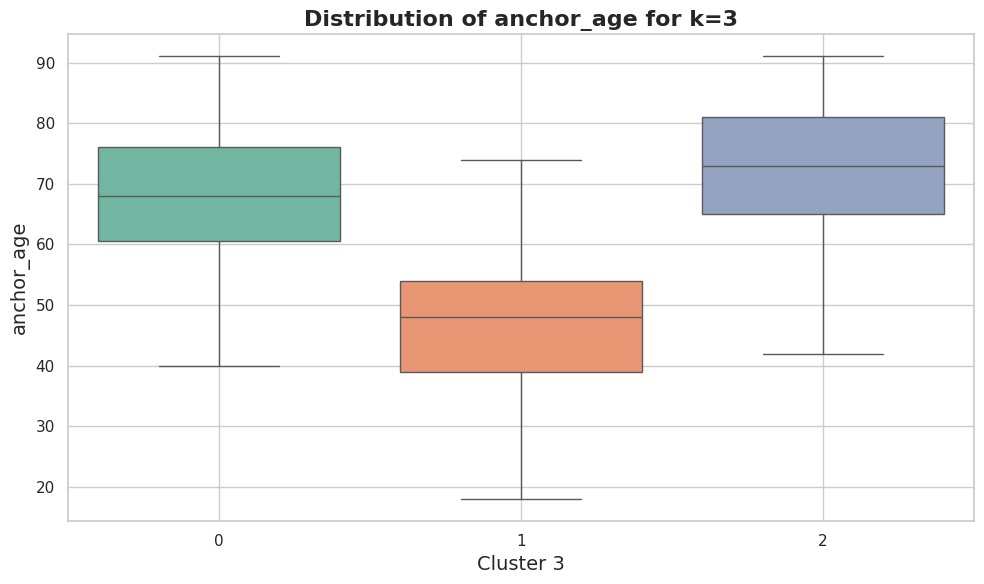

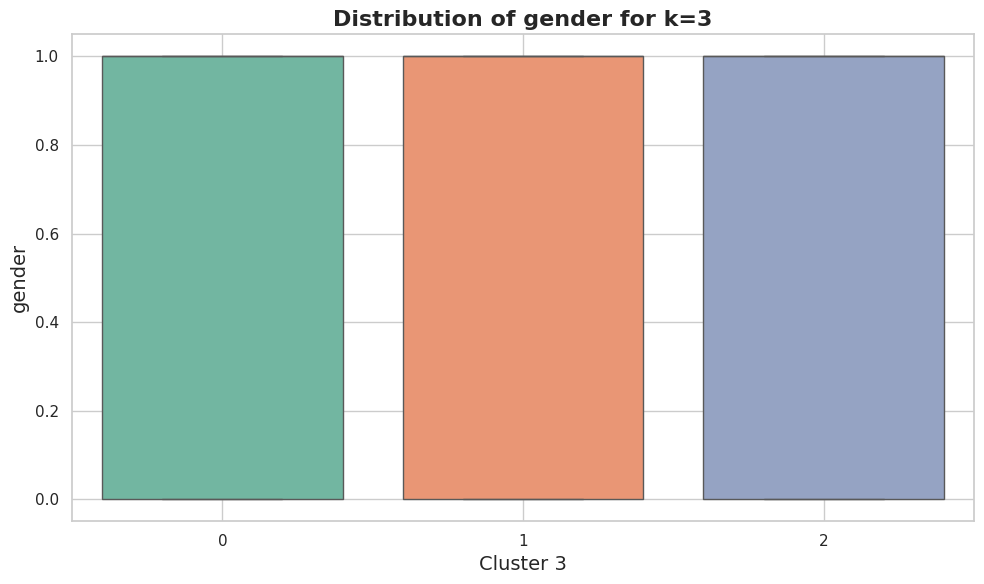

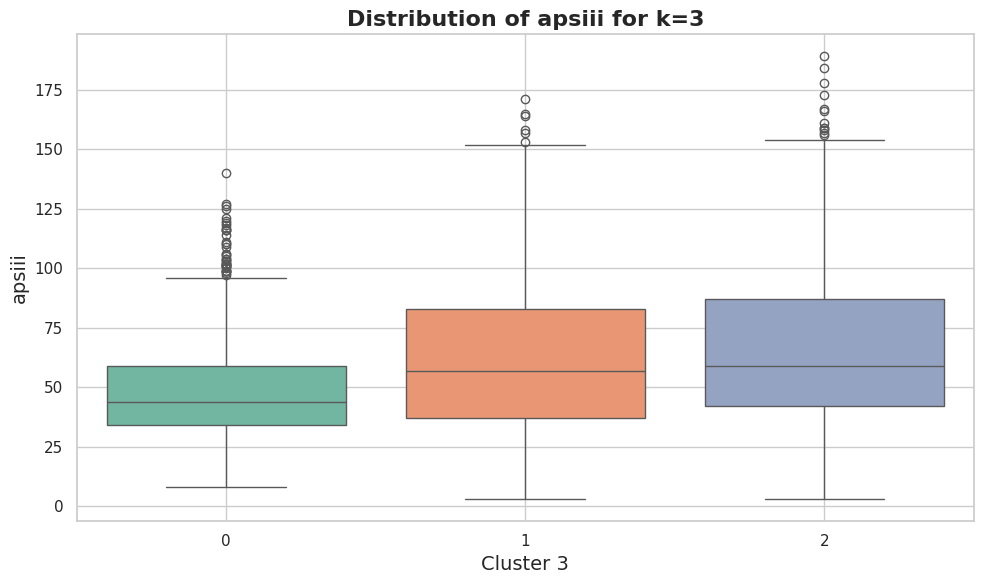

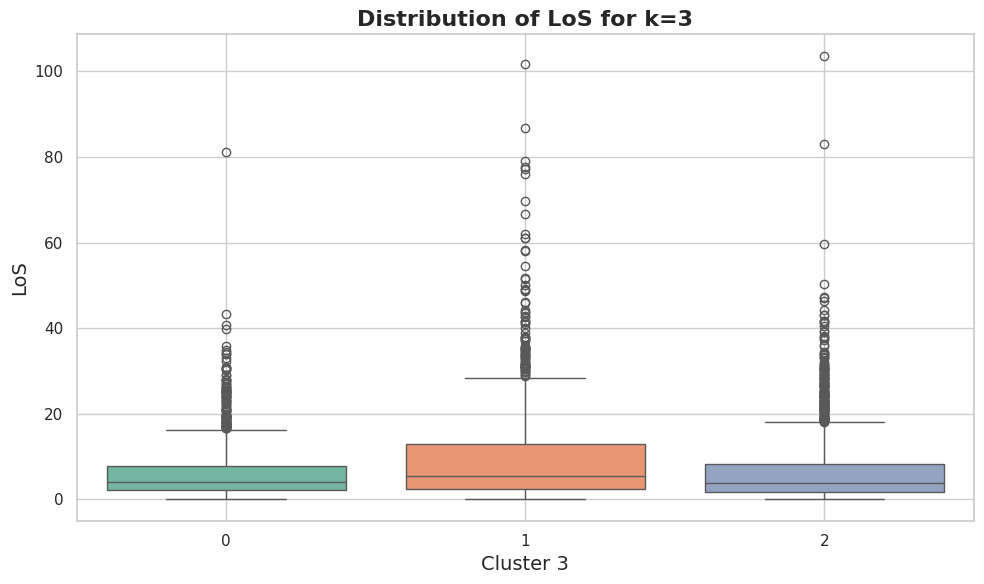

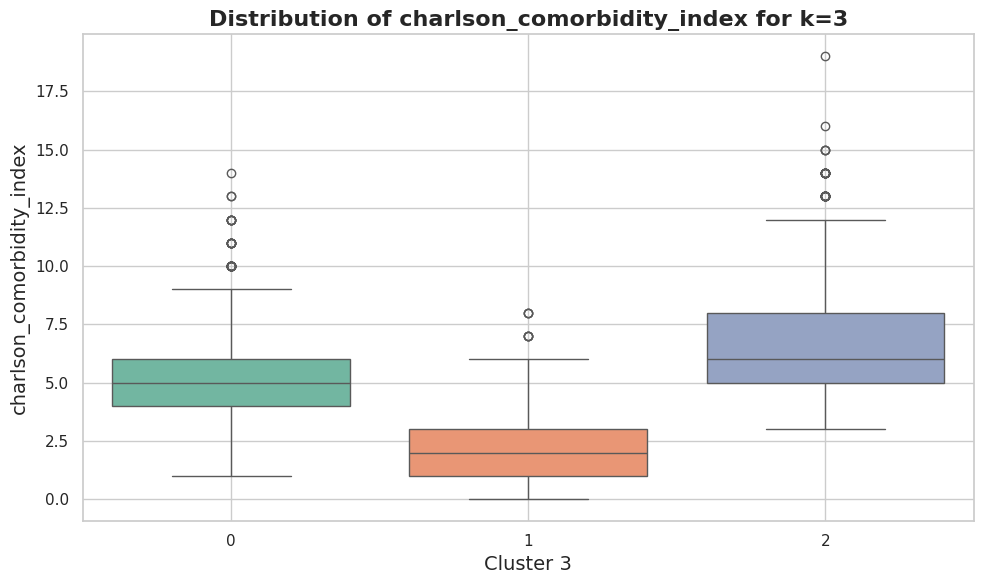

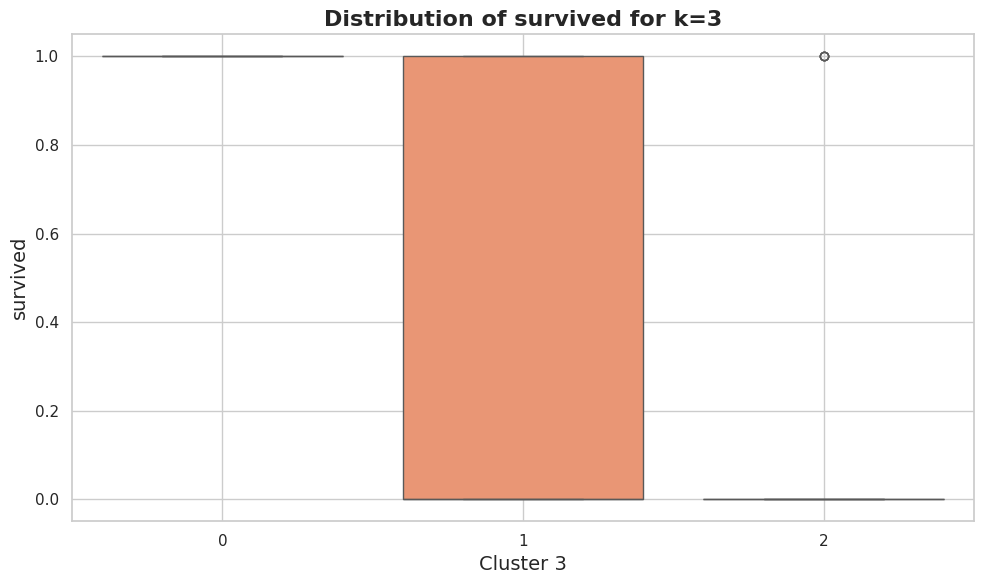

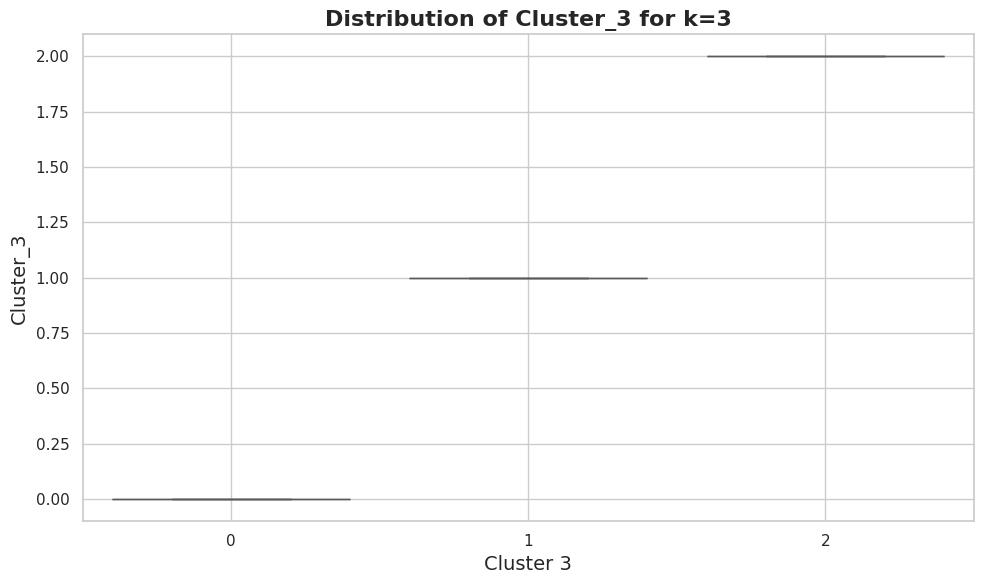

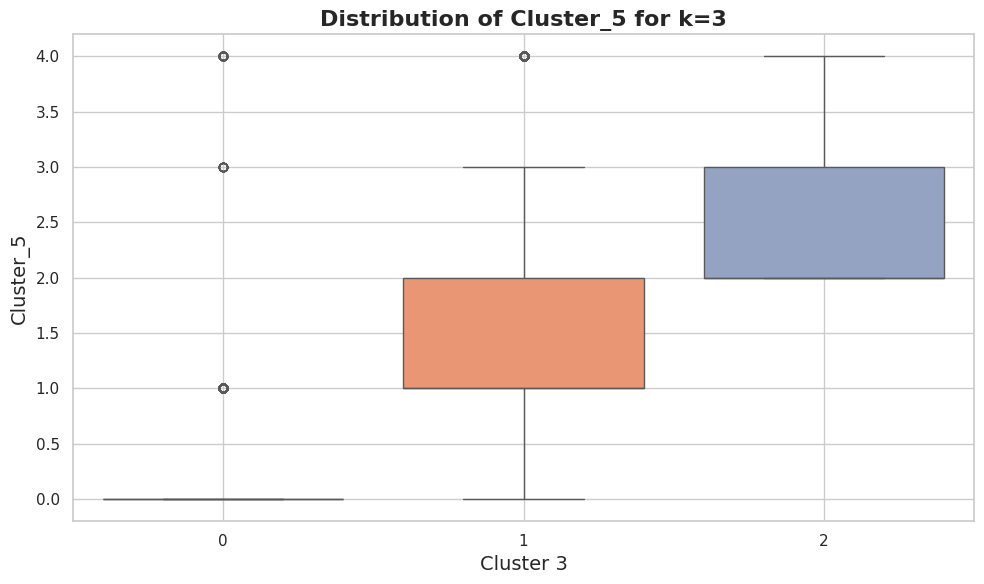

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme for plots
sns.set_theme(style="whitegrid")

# Plotting boxplots for k=3
k = 3
for column in cohort_df.columns[:-1]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=f'Cluster_{k}', y=column, data=cohort_df, hue=f'Cluster_{k}', palette="Set2", legend=False)
    plt.title(f'Distribution of {column} for k={k}', fontsize=16, weight='bold')
    plt.xlabel(f'Cluster {k}', fontsize=14)
    plt.ylabel(f'{column}', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


**Distribution of Patient Characteristics Across Clusters for k=5**

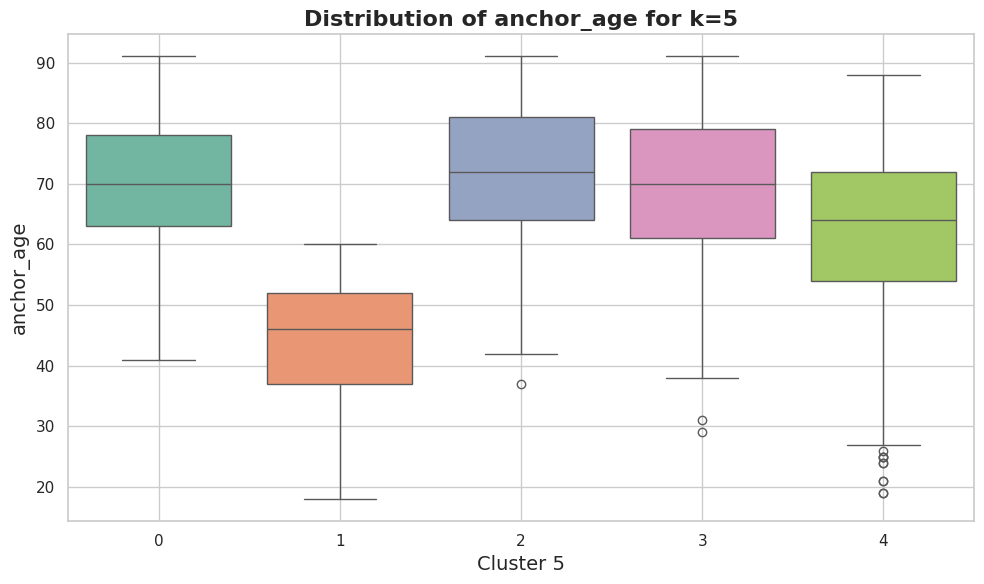

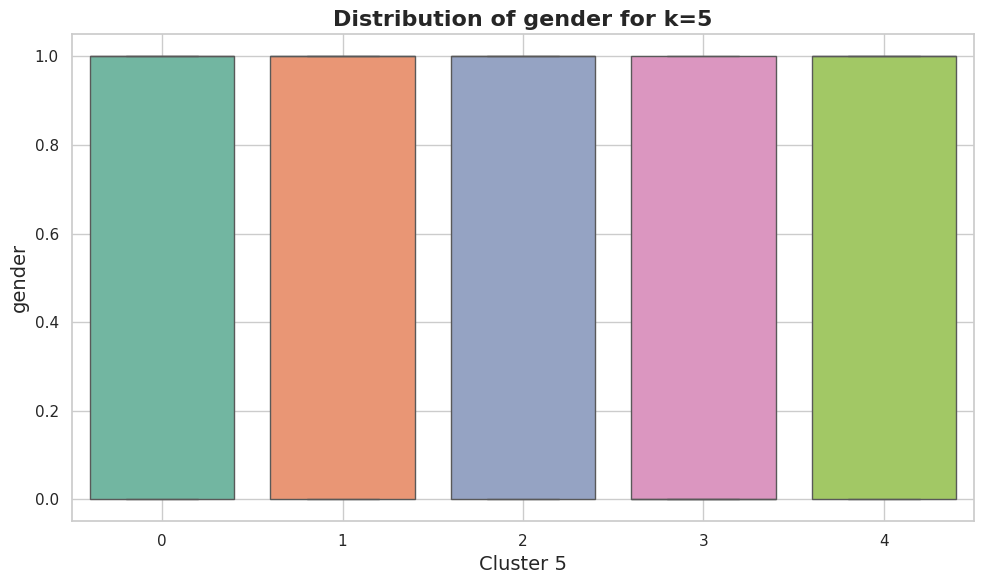

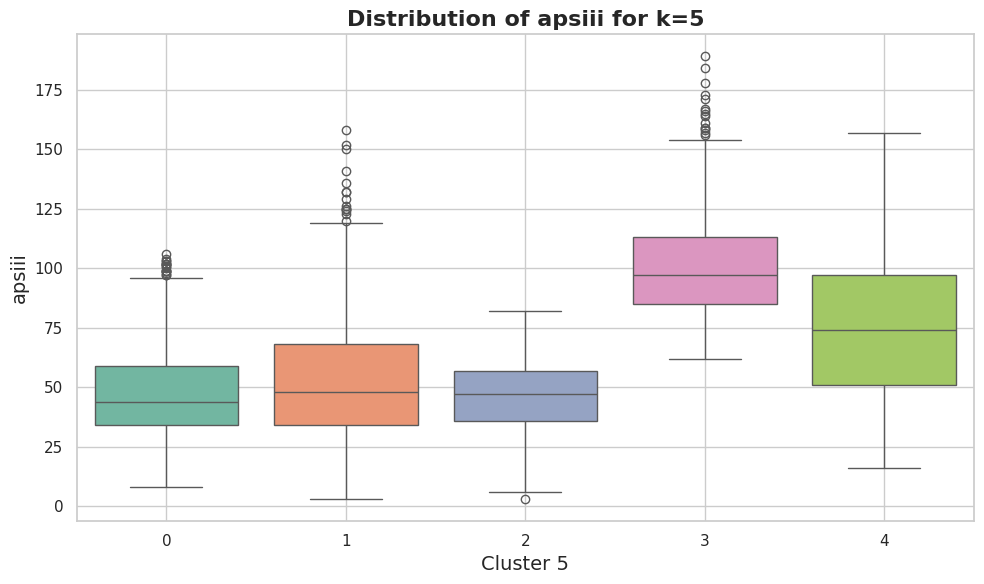

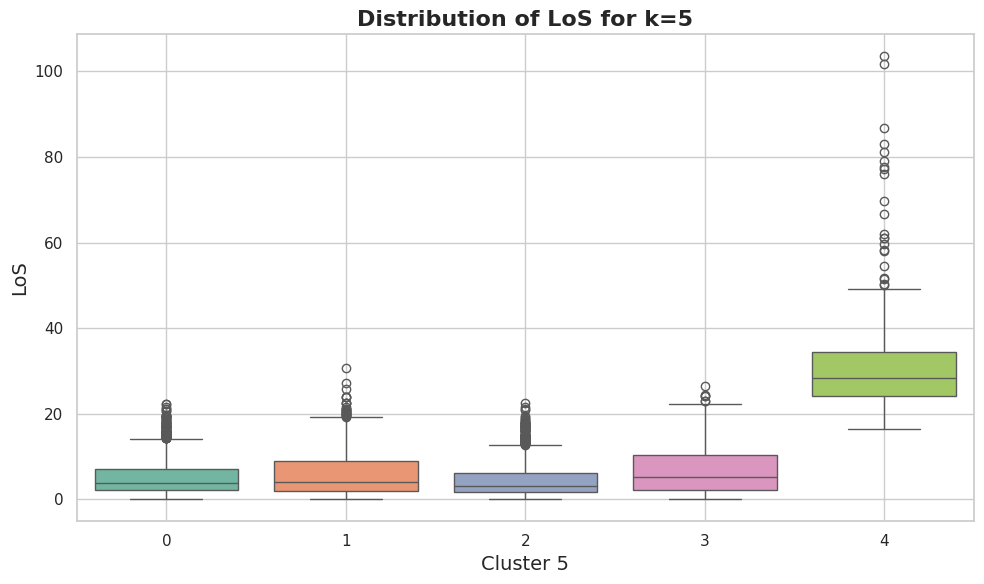

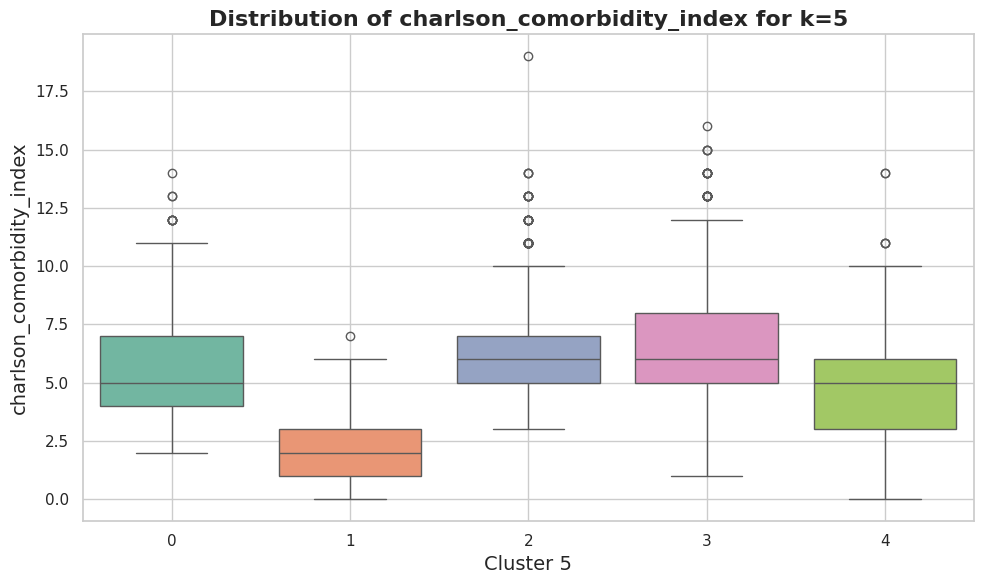

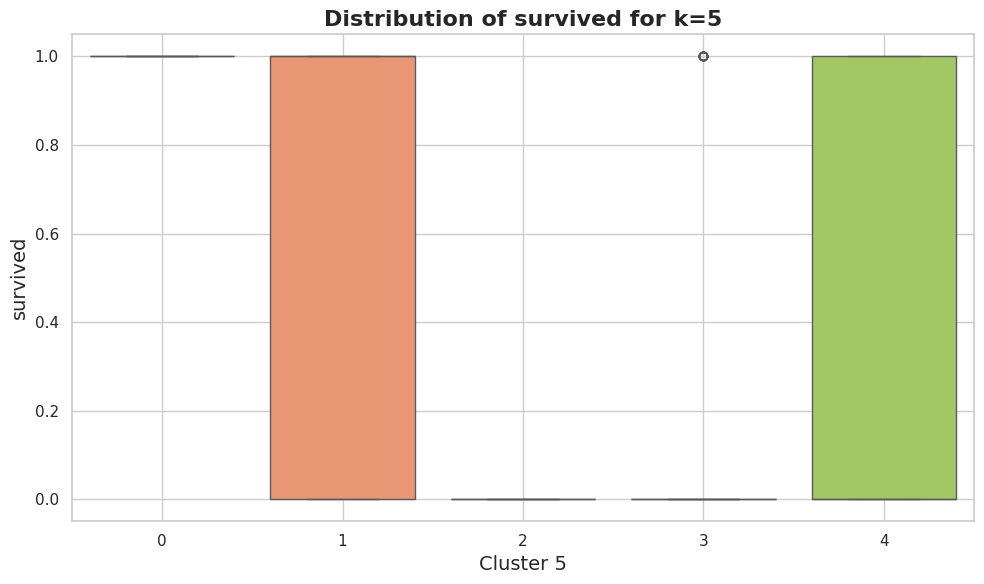

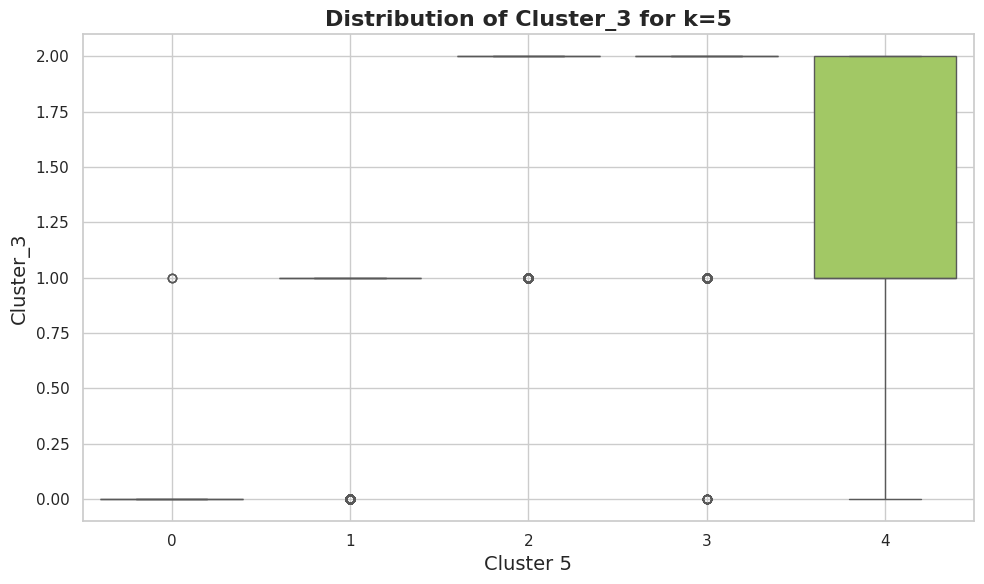

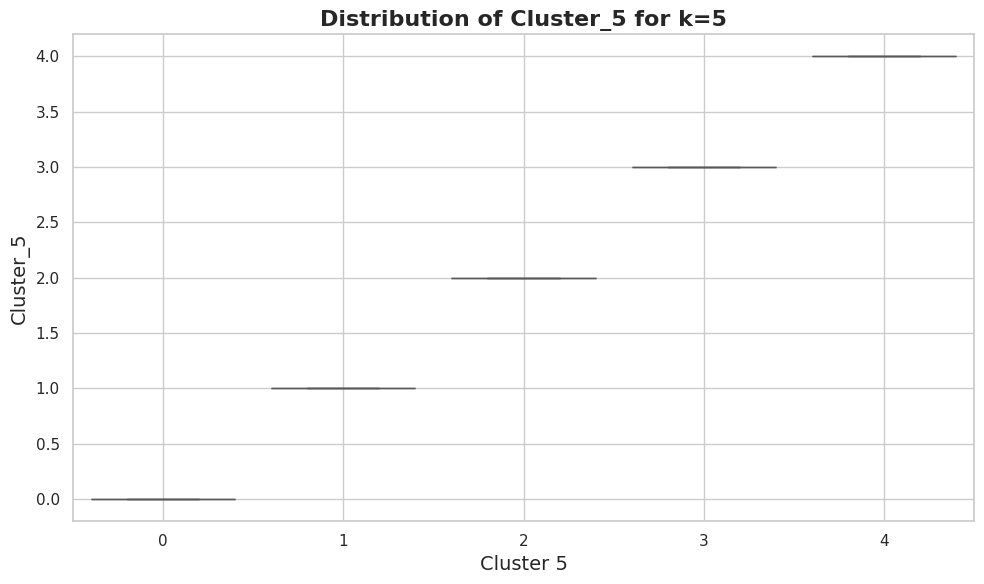

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme for plots
sns.set_theme(style="whitegrid")

# Plotting boxplots for k=3
k = 5
for column in cohort_df.columns[:-1]:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=f'Cluster_{k}', y=column, data=cohort_df, hue=f'Cluster_{k}', palette="Set2", legend=False)
    plt.title(f'Distribution of {column} for k={k}', fontsize=16, weight='bold')
    plt.xlabel(f'Cluster {k}', fontsize=14)
    plt.ylabel(f'{column}', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#Q3 Property differences between the clusters

### Main Property Differences Between the Clusters

The clusters reveal important differences in patient characteristics such as **age**, **severity of illness (APSIII scores)**, **length of stay (LoS)**, **comorbidity index**, and **survival rates**, as shown in the **plots above**.

- **Age**: In cluster 3 (as seen in the **age distribution plot above**), I noticed two distinct age groups: one in their early 50s and the other in their 70s. When I looked at cluster 5, the differences became even more refined, showing patients ranging from their 40s to their 70s. This highlights how age plays a crucial role in separating these clusters, especially when it comes to older patients who typically require more intensive care.

- **APSIII (Severity of Illness)**: The **APSIII score plots above** show that patients in certain clusters (like cluster 2 in the three-cluster model) experience more severe illness. In the five-cluster model, I could see even greater variation, with some patients facing extreme illness. These clusters effectively pinpoint the patients in critical condition who may need immediate intervention.

- **Length of Stay (LoS)**: Both cluster 3 and 5 highlight groups of patients who tend to have shorter stays, while others stay in the ICU for over 20 days, as seen in the **LoS plots above**. The patients with longer ICU stays generally face more severe conditions, which impacts their overall recovery time.

- **Charlson Comorbidity Index**: The **comorbidity index plots above** show that some clusters consist of patients with multiple chronic conditions. In cluster 5, there’s even greater variation, where higher comorbidity scores often predict worse outcomes.

- **Survival Rates**: The **survival plots above** clearly show that certain clusters, especially those with higher APSIII scores and comorbidities, have much lower survival rates. In cluster 5, I noticed that survival is particularly low in specific groups, reinforcing the link between severe illness, chronic conditions, and survival chances.

### How These Differences Relate to Outcomes

In general, the clusters align well with patient outcomes. I observed that older patients, those with higher severity scores, longer ICU stays, and more comorbidities tend to have poorer outcomes and lower survival rates. These visualizations help me understand the importance of early, targeted care for patients at the highest risk.

In [83]:
!pip freeze > requirements.txt


Link to Git - https://github.com/divyanshu8888/ML_Health